In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path
%matplotlib inline

In [3]:
# Read CSV, parse dates, set index
csvpath = Path('../Resources/gold_aud.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
df.head()

,Open,High,Low,Close
Date,,,,
2001-01-02,400.90,400.90,400.90,400.90
2001-01-03,401.68,401.68,401.68,401.68
2001-01-04,400.51,400.51,400.51,400.51
2001-01-05,401.92,401.92,401.92,401.92
2001-01-08,400.42,400.42,400.42,400.42


In [4]:
# Calculate return and lagged return
df['Return'] = df['Close'].pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

,Open,High,Low,Close,Return,Lagged_Return
Date,,,,,,
2001-01-04,400.51,400.51,400.51,400.51,-0.291277,0.194562
2001-01-05,401.92,401.92,401.92,401.92,0.352051,-0.291277
2001-01-08,400.42,400.42,400.42,400.42,-0.373209,0.352051
2001-01-09,399.73,399.73,399.73,399.73,-0.172319,-0.373209
2001-01-10,395.55,395.55,395.55,395.55,-1.045706,-0.172319


<AxesSubplot:xlabel='Date'>

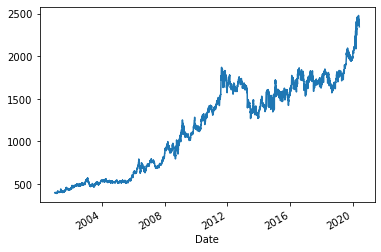

In [5]:
# Plot closing price
df['Close'].plot()

# Train Test Split Predictions

Training Period: 2001-2018
Testing Period: 2019

In [6]:
# Create a train/test split for the data using 2001-2018 for training and 2019 for testing
train = df['2001':'2018']
test = df['2019']

<ipython-input-6-92b73fe1f037>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = df['2019']


In [7]:
# Create train and test sets for dependent and independent variables
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [8]:
# Create and fit model to the data, make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [11]:
# Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

<AxesSubplot:xlabel='Date'>

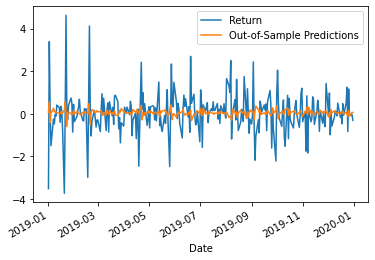

In [13]:
# Plot the out-of-sample results for 2019
out_of_sample_results.plot()

In [14]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 0.9612356236607867


---

# Rolling Out-of-Sample Predictions

In [15]:
# Split the index into weekly periods
weeks = df.index.to_period("w").unique()
print(weeks[0])

2001-01-01/2001-01-07


In [17]:
# Declare the training window of 12 weeks
# Define the timeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

1001


In [18]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [19]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df.loc[start_of_training_period:end_of_training_period]
    test = df.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [20]:
# Concat actual returns with out-of-sample predictions
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2001-04-02,-0.577978,0.023480
2001-04-03,0.168217,0.023246
2001-04-04,0.432184,0.023678
2001-04-05,-0.115573,0.023831
2001-04-06,0.152634,0.023514


In [21]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019

,Actual Returns,Out-of-Sample Predictions
2019-01-01,-3.522136,0.297019
2019-01-02,3.387913,1.657992
2019-01-03,0.157490,-1.082357
2019-01-04,-1.505112,0.198747
2019-01-07,-0.258793,0.840975
...,...,...
2020-05-27,-0.286804,0.187017
2020-05-28,0.169292,0.178567
2020-05-29,1.410067,0.175123
2020-06-01,-1.517733,0.232197


<AxesSubplot:>

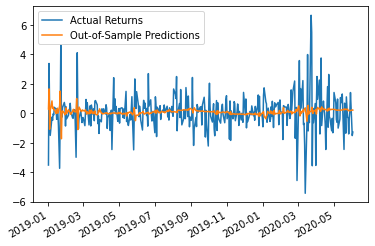

In [24]:
# Plot the results
results_2019.plot()

In [25]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    results_2019["Actual Returns"],
    results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 1.2335477556805383


# Final Model Comparison

In [26]:
# Print out-of-sample RMSE and rolling out-of-sample RMSE
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 0.9612356236607867
Rolling Out-of-Sample Root Mean Squared Error (RMSE): 1.2335477556805383


Question: How does the RMSE for the two models compare?

Answer: